# [Computational Social Science]
## 2-3 Regression - Solutions

In this lab, we are going to cover **Regression** methods. Supervised machine learning can be divided into classification and regression. We will begin with regression as a review of your previous statistics courses. This lab will introduce the regression methods available in the scikit-learn extension to scipy, focusing on ordinary least squares linear regression, LASSO, and Ridge regression.

---


### Table of Contents


1 - [Data Splitting Review](#section_1)

2 - [Linear Regression](#section_2)

3 - [Ridge Regression](#section_3)

4 - [LASSO Regression](#section_4)

5 - [Hyperparameter Tuning](#section_5)

6 - [Choosing a Model](#section_6)



## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

In [1]:
# load libraries 
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# use magic function
%matplotlib inline


# set style
sns.set_style("darkgrid")

## The Data: Bike Sharing

In your time at Cal, you've probably passed by one of the many bike sharing station around campus. Bike sharing systems have become more and more popular as traffic and concerns about global warming rise. This lab's data describes one such bike sharing system in Washington D.C., from [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [2]:
#  load data 
bike = pd.read_csv('../../data/day.csv')

# reformat the date column to integers representing the day of the year, 001-366
bike['dteday'] = pd.to_datetime(np.array(bike['dteday'])).strftime('%j')

# get rid of the index column
bike = bike.drop('instant', axis=1)

# inspect
bike.head(5)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Take a moment to get familiar with the data set. In data science, you'll often hear rows referred to as **records** and columns as **features**. Before you continue, make sure you can answer the following:

- How many records are in this data set?
- What does each record represent? (How is the data structured?)
- What are the different features?
- How is each feature represented? What values does it take, and what are the data types of each value?

Explore the dataset and answer these questions.

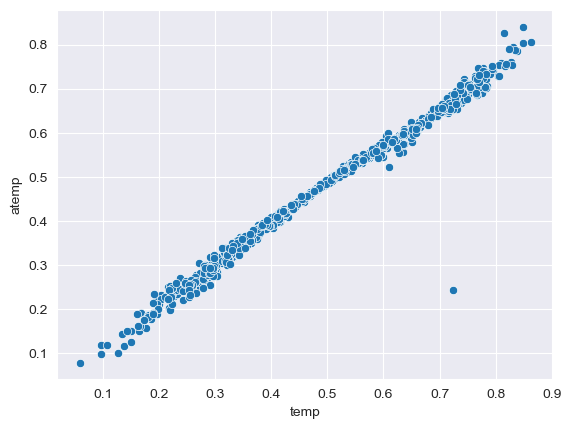

In [34]:
# you might look at the dataset
bike.head(5)

# create a scatterplot  
sns.scatterplot(x ='temp', 
                y = 'atemp', 
                data=bike);

In [4]:
# print out the dataframe's records and features
print(f"dataset has {bike.shape[0]} rows and {bike.shape[1]} columns")

dataset has 731 rows and 15 columns


Features include numerical features for day of the year, season, month, whether the day is a holiday, whether it's a weekday or working day, temp, wind speed etc. See https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset for explanations.

---
## 1. The Test-Train-Validation Split  <a id='section_1'></a>

Today, we want to see what factors affect ridership. But first, recall from last week that before we make predictions, we need to split our data first. 

So, let's prepare the bike dataset by creating a dataframe **X** with all of the features (exclude anything that is not a rider count), and a series, **y** with the *total number of riders*. 

In [5]:
# the features used to predict riders
X = bike.drop(['casual', 'registered', 'cnt'],  # list of variables to drop
              axis=1)                           # specify which axis to drop by: 0 = rows, 1 = columns

# the number of riders
y = bike.cnt                                   # new way to subset a specific column

Next, set the random seed using `np.random.seed(...)`. This will affect the way numpy pseudo-randomly generates the numbers it uses to decide how to split the data into training and test sets. Any seed number is fine- the important thing is to document the number you used in case we need to recreate this pseudorandom split in the future.

Then, call `train_test_split` on your X and y. Also set the parameters `train_size=` and `test_size=` to set aside 80% of the data for training and 20% for testing.

In [6]:
# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,    # specify proportional split for training
                                                    test_size=0.2)     # specify proportional split for test

### The Validation Set

Recall that our test data should only be used once: after our model has been selected, trained, and tweaked. Unfortunately, it's possible that in the process of tweaking our model, we could still overfit it to the training data and only find out when we return a poor test data score. What then?

A **validation set** can help here. By trying your trained models on a validation set, you can (hopefully) weed out models that don't generalize well.

Call `train_test_split` again, this time on your X_train and y_train. We want to set aside 25% of the data to go to our validation set, and keep the remaining 75% for our training set.

Note: This means that out of the original data, 20% is for testing, 20% is for validation, and 60% is for training.

In [7]:
# split the data so that it returns 4 values: X_train, X_validate, y_train, y_validate
X_train, X_validate, y_train, y_validate = train_test_split(X_train, 
                                                            y_train,
                                                            train_size=0.75, 
                                                            test_size=0.25)

## 2. Linear Regression (Ordinary Least Squares) <a id='section_2'></a>

Now, we're ready to start training models and making predictions. We'll start with a **linear regression** model.

[Scikit-learn's linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) is built around scipy's ordinary least squares, which you used in the last lab. The syntax for each scikit-learn model is very similar:
1. Create a model by calling its constructor function. For example, `LinearRegression()` makes a linear regression model.
2. Train the model on your training data by calling `.fit(train_X, train_y)` on the model

Create a linear regression model in the cell below, and fit it to the training data.

In [8]:
# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

With the model fit, you can look at the best-fit slope for each feature using `.coef_`, and you can get the intercept of the regression line with `.intercept_`.

In [9]:
# print model coefficients and intercept
print(lin_model.coef_)
print(lin_model.intercept_)

[  -14.18033852   476.05152957  2074.99361806   391.42859423
  -548.21392825    51.99824278    74.52205017  -654.9048012
 -3639.09456149 10029.50716836  -548.30835199 -2204.11280459]
840.1967135427694


We can also visualize the coefficients. Fill in the code below to produce a bar plot for the coefficients.
Reminder: Seaborn's barplot takes arguments for `x`, `y` and `data`. You can take `x` and `y` from the DataFrame created below!

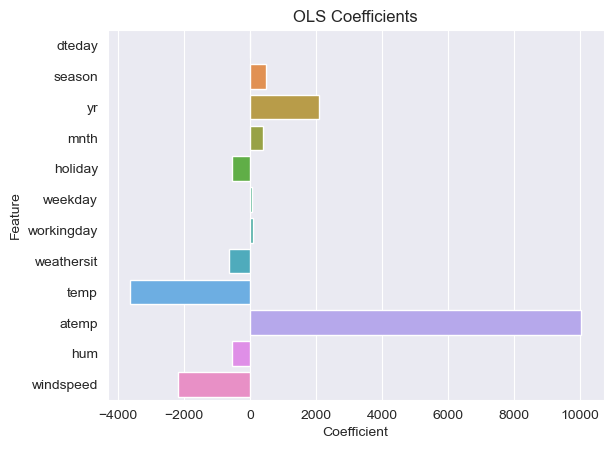

In [10]:
# create a dataframe with the coefficient and feature names for plotting
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T # make a dataframe from the arrays
lin_reg_data.columns = ['Coefficient', 'Feature']           # add column names for clarity

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()                                                  # show plot

Now, let's get a sense of how good our model is. We can do this by looking at the difference between the predicted values and the actual values, also called the error.

We can see this graphically using a scatter plot.

- Call `.predict()` on your linear regression model (`lin_model`), using your validation X, to return a list of predicted number of riders per hour. Save it to a variable `lin_pred`.
- Using a scatter plot (`plt.scatter(...)`), plot the predicted values against the actual values (`y_validate`)

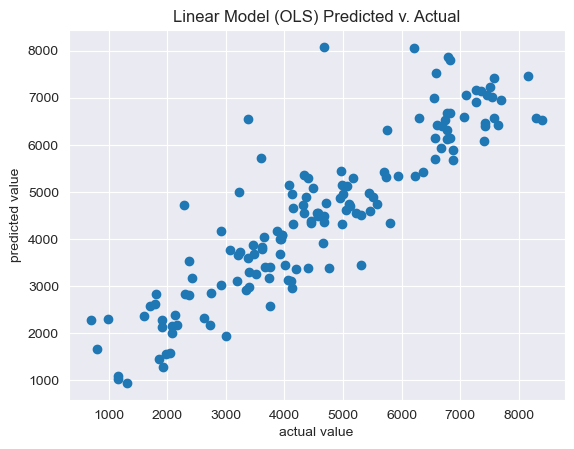

In [11]:
# using the validation dataset and the trained model, predict the number of riders 
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

**QUESTION:** What should our scatter plot look like if our model was 100% accurate?

**ANSWER:** All points (i.e. errors) would fall on a line with a slope of one: the predicted value would always equal the actual value.

We can also get a sense of how well our model is doing by calculating the **root mean squared error**. The root mean squared error (RMSE) represents the average difference between the predicted and the actual values.

To get the RMSE:
- subtract each predicted value from its corresponding actual value (the errors)
- square each error (this prevents negative errors from cancelling positive errors)
- average the squared errors
- take the square root of the average (this gets the error back in the original units)

Write a function `rmse` that calculates the mean squared error of a predicted set of values.

In [12]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

Now calculate the mean squared error for your linear model (`lin_pred`), using the y validation set.

In [13]:
# calculate root mean squared errror
rmse(lin_pred,     # specify predicted values 
     y_validate)   # specify actual values values 

851.143241027342

## 3. Ridge Regression <a id='section_3'></a>

Now that you've gone through the process for OLS linear regression, it's easy to do the same for [**Ridge Regression**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). In this case, the constructor function that makes the model is `Ridge()`.

*Tip: the `alpha` parameter controls the regularization strength. Its default is 1 -- try changing it to see what happens.*

In [14]:
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

Plot the coefficients for the Ridge alongside the OLS model to compare them. 

**QUESTION:** How do they compare to the coefficients for OLS?

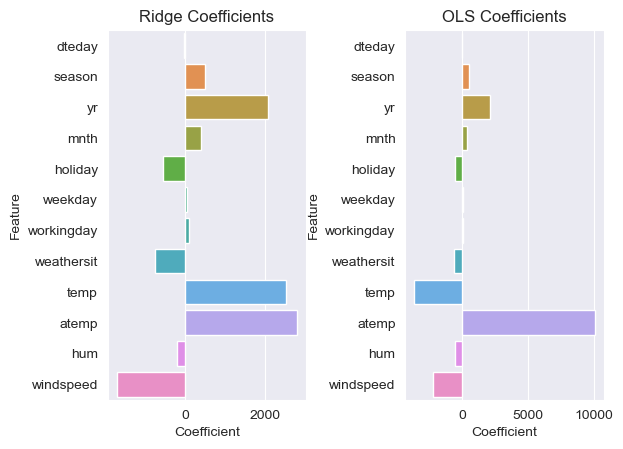

In [15]:
# set the figure parameters
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .5, hspace=.5)   # adjust the space in between figures 

# plot 1
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   1)   # specifies the following code is for the first plot  

# specify barplot for Ridge
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge Coefficients")

# plot 2
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   2)   # specifies the following code is for the second plot 

# specify barplot for OLS
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lin_reg_data).set_title("OLS Coefficients")

# show the plots
plt.show()

**ANSWER:**: The coefficients on the Ridge regression are smaller. Some of them are flipped (e.g. temp). 

Now use your Ridge model to make predictions and visualize the predictions against the actual values. 

**QUESTION:** How does the RMSE compare?

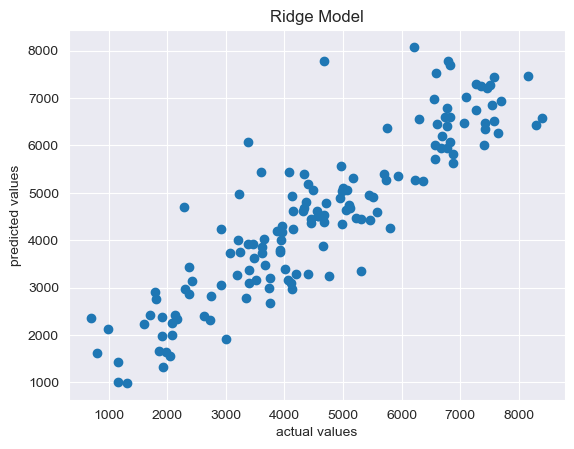

In [16]:
# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [17]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_validate)

850.1206770970779

**ANSWER:** The `rmse` for the Ridge regression is slightly smaller, suggeting a better fit.

Note: the documentation for Ridge regression shows it has lots of **hyperparameters**: values we can choose when the model is made. Now that we've tried it using the defaults, look at the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). In a bit, we will try changing some parameters to see if we can get a lower RMSE.

## 4. LASSO Regression <a id='section_4'></a>

Finally, we'll try using [LASSO regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). The constructor function to make the model is `Lasso()`. 

You might get a warning message saying the objective did not converge. The model will still work, but to get convergence try increasing the number of iterations (`max_iter=`) when you construct the model. This will generally be an issue if the max number of iterations is less than 2000. Let's set it to 10,000 so we don't have to worry about this. 

In [18]:
# create and fit the model
lasso_reg = Lasso(max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

Plot the coefficients for Ridge and LASSO. 

**QUESTION:** How do they compare?

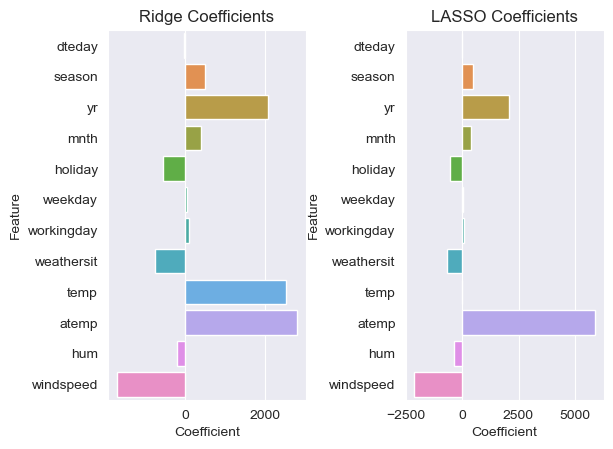

In [19]:
# set the figure 
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .5, hspace=.5)   # adjust the space in between figures 

# plot 1
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   1)   # specifies the following code is for the first plot  

# specify barplot for Ridge 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge Coefficients")

# plot 2
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   2)   # specifies the following code is for the second plot 

# specify barplot for LASSO 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lasso_reg_data).set_title("LASSO Coefficients")

# show the plot
plt.show()

**ANSWER:** LASSO shrank some coefficients down to 0 entirely, thus performing feature selection. Of the coefficients that remain; however, LASO tends to produce smaller ones, except for "atemp".

Now use your LASSO model to make predictions and visualize the predictions against the actual values. How does the RMSE compare?

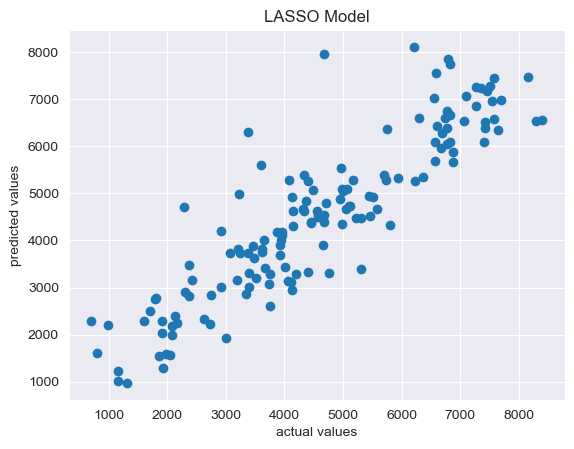

In [20]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [21]:
# calculate the rmse for the LASSO model
rmse(lasso_pred, y_validate)

847.6822999450297

Note: LASSO regression also has many tweakable hyperparameters. See how changing them affects the accuracy!

**QUESTION:** How do these three models compare on performance? What sorts of things could we do to improve performance?

**ANSWER:** All three models have very similar accuracy, around 850 RMSE for each.

## 5. Hyperparameter Tuning  <a id='section_5'></a>
---

Looking at the documentation, you might have noticed that there were a number of arguments that you could supply to each algorithm. How do we decide what the optimal settings are? This process is known as **[hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)**. Hyperparameters are essentially settings that control how the machine learning algorithm learns relationships between features and targets, and are fixed by the analyst. 

Here, we are going to learn how to accomplish this task using **grid search**. Grid search means we specify a list of hyperparameter specifications that we want to try out, and then we search through all combinations of these specifications. Luckily, Python creates an easy way to do this with its [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html) method. This approach combines doing an exhaustive search of hyperparameter values with cross-validation.

Look at the documentation for linear regression, and fill in the hyperparameters below. *Note that the `.get_params()` method will show you the hyperparameters available for your different regressor models.*

In [22]:
# see parameters for linear regression
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [23]:
# see parameters for Ridge regression
ridge_reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [24]:
# see parameters for Lasso regression
lasso_reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 15000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [25]:
# Linear regression 

# specify the hyperparameters
param_grid = {'fit_intercept': [True, False]}          # use dictionary for tuning

# execute the grid search
lin_grid_reg = GridSearchCV(estimator  = lin_reg,      # model to be tuned
                            param_grid = param_grid,   # parameters to be searched as specified above
                            cv=3)                      # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lin_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset
best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)     # find best estimator and predict on validate

# print the results  
print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lin_pred, y_validate))

{'fit_intercept': True}
Best CV R^2: 0.7887367847533672
Validation R^2: 0.7953553051938631
Validation RMSE 851.143241027342


Next, implement a grid search for both Ridge and LASSO. In particular, make sure to search across a variety of alpha values in addition to varying other hyperparameters.

*Recall: `GridSearchCV` takes two arguments: a model and a dict of parameter variations (`param_grid`).*

In [26]:
# RIDGE: We will run 9*2*4 = 72 tests, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

Best CV R^2: 0.7874299119663304
Validation R^2: 0.7982593680546192
Validation RMSE 845.0824796220629


(By the way: Here is what we would do if we would have to do this hyperparameter tuning by hand. We'd have to create a new regression model with different hyperparameters each time, then run cross-validation to see which of the models would be best. Obviously this would take forever.)

In [27]:
# example of how to do this by hand
from sklearn.model_selection import cross_val_score

# set specification 1
ridge_reg = Ridge(alpha=.1)
print(np.mean(cross_val_score(ridge_reg, X_train, y_train, cv = 3)))

# set specification 2
ridge_reg = Ridge(alpha=.2)
print(np.mean(cross_val_score(ridge_reg, X_train, y_train, cv = 3)))

# set specification 3
ridge_reg = Ridge(alpha=.3)
print(np.mean(cross_val_score(ridge_reg, X_train, y_train, cv = 3)))

0.7874299119663299
0.7869392652063159
0.7866227321846712


Using `GridSearchCV`, we can just get the scores for each of our 72 parameter combinations like so:

In [28]:
ridge_grid_reg.cv_results_["mean_test_score"]

array([0.78742991, 0.78742991, 0.78742991, 0.78287995, 0.78327806,
       0.78327806, 0.78327806, 0.77681296, 0.78693927, 0.78693927,
       0.78693927, 0.78296749, 0.78238472, 0.78238472, 0.78238472,
       0.77683443, 0.78662273, 0.78662273, 0.78662273, 0.782819  ,
       0.78198652, 0.78198652, 0.78198652, 0.77684039, 0.78634181,
       0.78634181, 0.78634181, 0.78074478, 0.78173812, 0.78173812,
       0.78173812, 0.77683132, 0.78606439, 0.78606439, 0.78606439,
       0.78071143, 0.78154489, 0.78154489, 0.78154489, 0.77659133,
       0.78578095, 0.78578095, 0.78578095, 0.78064995, 0.78137173,
       0.78137173, 0.78137173, 0.7765513 , 0.78548855, 0.78548855,
       0.78548855, 0.7805629 , 0.78120331, 0.78120331, 0.78120331,
       0.77649779, 0.78518649, 0.78518649, 0.78518649, 0.78101108,
       0.78103226, 0.78103226, 0.78103226, 0.7764312 , 0.78487482,
       0.78487482, 0.78487482, 0.78085551, 0.78085487, 0.78085487,
       0.78085487, 0.77635195])

We then just pick the best score with `best_estimator_`, corresponding to a particular set of hyperparameters.

In [29]:
# LASSO: 

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])   # find the best performing model
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)    # find best estimator and predict on validate

# print results
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

{'alpha': 0.1, 'fit_intercept': True, 'selection': 'random'}
Best CV R^2: 0.7887507531295442
Validation R^2: 0.7961674304813988
Validation RMSE 849.4526961061583


## 6.  Choosing a model <a id='section_6'></a>
---
### Test Set

Choose your best model with the best hyperparameter values and try it on the test set. How well does it do?

Make sure to look at the documentation for [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and see which methods are available.

*Tip: first, apply the `.best_estimator_.predict()` method to one of your GridSearchCV objects--`lin_grid_reg`, `ridge_grid_reg`, or `lasso_grid_reg`--depending on which one was most succesful.*

In [30]:
# Best Linear model

best_pred = lin_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', lasso_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred, y_test))

Best CV R^2: 0.7887507531295442
Test R^2: 0.7588382300244374
Test RMSE 971.1803232266325


In [31]:
# Best Ridge model 

best_pred = ridge_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', lasso_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred, y_test))

Best CV R^2: 0.7887507531295442
Test R^2: 0.7588382300244374
Test RMSE 921.4112978487415


In [32]:
# Best LASSO model

best_pred = lasso_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', lasso_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred, y_test))

Best CV R^2: 0.7887507531295442
Test R^2: 0.7588382300244374
Test RMSE 957.4452841668331


**QUESTIONS:** 
1. How do the RMSEs for the test data compare to those for the training and validation data? Why? 
2. Did the model that performed best on the training and validation set also do best on the test set?

**ANSWER:** The RMSE for the validation set tends to be larger than for the training set, simply because the models were fit to the training data.

Coming up this semester: how to select your models, model parameters, and features to get the best performance.

---
Authored by Aniket Kesari. Materials borrowed from notebook developed by Keeley Takimoto for LS123: Data, Prediction, and Law. Updated by Tom van Nuenen in 2022.